In [1]:
!pip install emoji wordsegment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import re
import emoji
import pandas as pd
from nltk.corpus import stopwords
from wordsegment import load, segment


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vishalthehuman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [4]:
# ---------------------------
# 1. Load and Combine Datasets
# ---------------------------
train_df = pd.read_csv("original/train.csv")
dev_df = pd.read_csv("original/dev.csv")
df = pd.concat([train_df, dev_df], ignore_index=True)
df

,id,text,label
0,3268,Indha ariya kandupidippin moolam neenga solla ...,0
1,6239,@vijayakumarp7959 unmai therincha nee pesu,0
2,5859,Inga erukka yella dev... boys vadakkan vadakk...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...,1
4,5136,Mumbai Bangalore la 80% percentage outsiders,1
...,...,...,...
6294,5860,This is done by those who want chaos in Tamil ...,0
6295,1441,"வடமாநிலத்தவருக்கு வேலை வாய்ப்பு கொடுப்பதை ,பணி...",0
6296,3253,நம்ம மேல எந்த தப்பும் இல்லை.... ஏன் என்றால் நா...,0
6297,4295,தம்பி உத்திரபிரதேசம் டெல்லி எல்லையில் உள்ள 90%...,1


In [5]:
df["label"].value_counts()

label
0    3900
1    2399
Name: count, dtype: int64

In [6]:
# -------------------------------
# Text Preprocessing
# -------------------------------
# Function to clean each text
# Load word segmentation model
load()

# Load stopwords
tamil_stopwords = set(stopwords.words('tamil'))
english_stopwords = set(stopwords.words('english'))

# -------------------------------
# Text Preprocessing
# -------------------------------

def preprocess_text(text):
    # Extract hashtags
    hashtags = re.findall(r"#\w+", text)

    # Process hashtags (convert to words)
    processed_hashtags = []
    for tag in hashtags:
        tag = tag.lstrip("#")  # Remove #
        words = segment(tag)   # Split compound words
        processed_hashtags.append(" ".join(words))  # Convert to sentence-like format

    # Remove hashtags from main text
    text = re.sub(r"#\w+", "", text)

    # Replace mentions with a placeholder
    text = re.sub(r'@\w+', '<USER>', text)
    
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))  # Adds spaces around emoji descriptions
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Merge cleaned text with processed hashtags
    final_text = text + " " + " ".join(processed_hashtags)
    final_text = final_text.replace("-", " ")  # Remove double spaces
    return final_text

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word.lower() not in english_stopwords and word.lower() not in tamil_stopwords]
    return ' '.join(filtered)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text).apply(remove_stopwords)

# Show sample processed data
df.sample(50)


,id,text,label,clean_text
1490,6304,Give evidence of pallar community in stone edict,0,Give evidence pallar community stone edict
276,7352,இந்த பெரியவர்தான் நாய் ல ஜாதி இருக்கு சொன்ன ஆள...,0,பெரியவர்தான் நாய் ல ஜாதி இருக்கு சொன்ன ஆளு.. வ...
1741,5929,அடிச்சு விரட்ட முடியாதவங்கள வதந்தி விரட்டிருச்...,0,அடிச்சு விரட்ட முடியாதவங்கள வதந்தி விரட்டிருச்...
607,6762,உண்மையை சொன்னீர்கள் சூப்பர் சூப்பர்,0,உண்மையை சொன்னீர்கள் சூப்பர் சூப்பர்
4433,3988,Holi festival ku poranga.. March 7 holi,0,Holi festival ku poranga.. March 7 holi
1818,5520,வட மாநிலத்தவர்கள் விரட்டப்பட்டார்களா 🤔\nஇல்லை ...,0,வட மாநிலத்தவர்கள் விரட்டப்பட்டார்களா thinking_...
5426,5618,1லட்சம் தமிழ் மக்கள் இலங்கை தமிழர்களை கொன்று வ...,0,1லட்சம் தமிழ் மக்கள் இலங்கை தமிழர்களை கொன்று வ...
945,4157,சீமானின் பேச்சு சிரிக்க சிந்திக்கக்கூடியது.......,0,சீமானின் பேச்சு சிரிக்க சிந்திக்கக்கூடியது.......
1996,6181,பார்ப்பனியம் என்று கூறப்படுவது பைபிளிலும் உள்ள...,0,பார்ப்பனியம் கூறப்படுவது பைபிளிலும் உள்ளது. அர...
3861,3765,தமிழக மீனவர்கள் வதைக்கப்படும் போது இந்த பரபரப்...,0,தமிழக மீனவர்கள் வதைக்கப்படும் பரபரப்பு இல்லையே...


In [7]:
df.shape

(6299, 4)

In [8]:
X = df['clean_text']

vectorizer = TfidfVectorizer(
    max_features=7000,
    ngram_range=(1,2),
    analyzer='word',
    token_pattern=r"(?u)\b\w+\b"
)

X_vectorized = vectorizer.fit_transform(X)
X_vectorized.shape


# import numpy as np
# import fasttext
# import fasttext.util

# # Step 1: Download and Load the Pretrained Tamil FastText Model
# fasttext.util.download_model('ta', if_exists='ignore')  # Tamil model (if not exists)
# model = fasttext.load_model('cc.ta.300.bin')  # Load Tamil FastText model

# # Step 2: Function to Convert Sentences into Sentence Embeddings
# def sentence_to_vec(sentence, model):
#     words = sentence.split()  # Tokenization
#     word_vectors = [model.get_word_vector(word) for word in words if word in model.words]
    
#     if not word_vectors:  # Handle empty case
#         return np.zeros(300)
    
#     return np.mean(word_vectors, axis=0)  # Average word embeddings

# # Step 3: Convert X_train and X_test Using FastText Embeddings
# X_vectorized = np.array([np.array(sentence) for sentence in X_vectorized])
X_vectorized = X_vectorized.toarray()
X_vectorized.shape

(6299, 7000)

In [9]:
X_vectorized.shape

(6299, 7000)

In [14]:
# X1 = np.load("muril_large_embeddings_after_aug.npy")
# X1.shape

In [45]:
# X2 = np.load("xlm_roberta_large_embeddings_after_aug.npy")
# X2.shape

In [10]:
import numpy as np

data = np.load("muril_large_embeddings_before_aug.npy")  # Replace "file.npy" with your actual file name
type(data)

numpy.ndarray

In [11]:
X_vectorized.shape

(6299, 7000)

In [12]:
X_final = np.zeros((X_vectorized.shape[0], X_vectorized.shape[1] + data.shape[1]))
X_final[:, :X_vectorized.shape[1]] = X_vectorized
X_final[:, X_vectorized.shape[1]:] = data
X_final.shape

(6299, 8024)

In [13]:
# for i in range(X_vectorized.shape[0]):
#     X_final[i, :] = np.concatenate((X_vectorized[i, :], data[i, :]))
# X_final.shape

In [14]:
# X_final

In [15]:
df.shape

(6299, 4)

In [16]:
# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, df['label'], test_size=0.2, stratify=df['label'], random_state=42)

In [17]:
# # -------------------------------
# # TF-IDF Vectorization (optimized for multilingual text)
# # -------------------------------
# vectorizer = TfidfVectorizer(
#     max_features=7000,
#     ngram_range=(1,2),
#     analyzer='word',
#     token_pattern=r"(?u)\b\w+\b"
# )

# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------
# Base estimators for Ensemble
# -------------------------------
base_estimators = [
    ('rf', RandomForestClassifier(class_weight='balanced')),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=2.0)),
    ('lgb', LGBMClassifier(class_weight='balanced'))
]

# -------------------------------
# Hyperparameter grids (unchanged, used optionally with GridSearchCV later)
# -------------------------------
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.05, 0.1]},
    'LightGBM': {'n_estimators': [100, 200], 'max_depth': [-1, 10], 'learning_rate': [0.05, 0.1]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Linear SVM': {'C': [0.1, 1, 10]}
}

# -------------------------------
# Ensemble Models
# -------------------------------
ensemble_models = {
    "Voting Classifier (Hard)": VotingClassifier(estimators=base_estimators, voting='hard'),
    "Voting Classifier (Soft)": VotingClassifier(estimators=base_estimators, voting='soft'),
    "Stacking Classifier": StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(solver='liblinear', class_weight='balanced')
    )
}

# -------------------------------
# Non-Ensemble Models with Class Weights
# -------------------------------
non_ensemble_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Linear SVM": LinearSVC(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(),  # doesn't support class_weight directly
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=2.0),
    "LightGBM": LGBMClassifier(class_weight='balanced')
}

# -------------------------------
# Final model dictionary
# -------------------------------
models = {**ensemble_models, **non_ensemble_models}


Training Models:   0%|          | 0/10 [00:00<?, ?it/s]


Training: Voting Classifier (Hard)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1919, number of negative: 3120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39071
[LightGBM] [Info] Number of data points in the train set: 5039, number of used features: 1212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:57:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30852
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31555
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 997
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31207
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 984
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:58:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31457
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 1003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1536, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31246
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Training Models:  10%|█         | 1/10 [01:29<13:27, 89.67s/it]

Cross-validation Accuracy (Mean ± Std): 0.7224 ± 0.0141

Training: Voting Classifier (Soft)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1919, number of negative: 3120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39071
[LightGBM] [Info] Number of data points in the train set: 5039, number of used features: 1212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30852
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31555
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 997
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31207
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 984
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31457
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 1003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1536, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31246
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Training Models:  20%|██        | 2/10 [02:55<11:37, 87.20s/it]

Cross-validation Accuracy (Mean ± Std): 0.7287 ± 0.0110

Training: Stacking Classifier


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1919, number of negative: 3120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39071
[LightGBM] [Info] Number of data points in the train set: 5039, number of used features: 1212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31322
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 995
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31400
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 1003
[LightGBM] [Info] [bi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30852
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:02:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 1228, number of negative: 1996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24583
[LightGBM] [Info] Number of data points in the train set: 3224, number of used features: 806
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1228, number of negative: 1997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24768
[LightGBM] [Info] Number of data points in the train set: 3225, number of used features: 817
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Light

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31555
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 997
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 1228, number of negative: 1996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25230
[LightGBM] [Info] Number of data points in the train set: 3224, number of used features: 817
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1228, number of negative: 1997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25194
[LightGBM] [Info] Number of data points in the train set: 3225, number of used features: 806
[LightGBM] [Info] [bin

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31207
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 984
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 1228, number of negative: 1996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25168
[LightGBM] [Info] Number of data points in the train set: 3224, number of used features: 817
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1228, number of negative: 1997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25071
[LightGBM] [Info] Number of data points in the train set: 3225, number of used features: 812
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Light

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31457
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 1003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:06:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 1228, number of negative: 1996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25270
[LightGBM] [Info] Number of data points in the train set: 3224, number of used features: 819
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1228, number of negative: 1997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24998
[LightGBM] [Info] Number of data points in the train set: 3225, number of used features: 814
[LightGBM] [Info] [bin

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:06:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1536, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31246
[LightGBM] [Info] Number of data points in the train set: 4032, number of used features: 992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 1229, number of negative: 1996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24874
[LightGBM] [Info] Number of data points in the train set: 3225, number of used features: 805
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1228, number of negative: 1997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24973
[LightGBM] [Info] Number of data points in the train set: 3225, number of used features: 802
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Light

Training Models:  30%|███       | 3/10 [10:36<30:05, 257.95s/it]

Cross-validation Accuracy (Mean ± Std): 0.7269 ± 0.0187

Training: Logistic Regression
Best Params for Logistic Regression: {'C': 10}


Training Models:  40%|████      | 4/10 [11:04<16:42, 167.14s/it]

Cross-validation Accuracy (Mean ± Std): 0.7162 ± 0.0077

Training: Linear SVM
Best Params for Linear SVM: {'C': 10}


Training Models:  50%|█████     | 5/10 [11:08<09:01, 108.36s/it]

Cross-validation Accuracy (Mean ± Std): 0.7095 ± 0.0114

Training: Decision Tree
Best Params for Decision Tree: {'max_depth': None}


Training Models:  60%|██████    | 6/10 [12:25<06:31, 97.84s/it] 

Cross-validation Accuracy (Mean ± Std): 0.6771 ± 0.0145

Training: Random Forest
Best Params for Random Forest: {'max_depth': None, 'n_estimators': 200}
Cross-validation Accuracy (Mean ± Std): 0.7541 ± 0.0039


Training Models:  70%|███████   | 7/10 [17:31<08:17, 165.79s/it]


Training: AdaBoost


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Best Params for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 100}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Cross-validation Accuracy (Mean ± Std): 0.6404 ± 0.0055


Training Models:  80%|████████  | 8/10 [24:13<08:02, 241.15s/it]


Training: XGBoost


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:21:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:23:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:24:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:24:13] WARNING: /Users/runner/work/xgboost/xgboost/src

Cross-validation Accuracy (Mean ± Std): 0.6454 ± 0.0091

Training: LightGBM
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Number of positive: 1536, number of negative: 2496
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30852
[LightGBM] [Info] Number of data points in the train set: 4031, number of used features: 989
[LightGBM] [Info] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 1919, number of negative: 3120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39071
[LightGBM] [Info] Number of data points in the train set: 5039, number of used features: 1212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Params for LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}
[LightGBM] [Info] Number of positive: 1535, number of negative: 2496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30852
[LightGBM] [Info] Number of data points in the train set: 4031, number of used f

Training Models: 100%|██████████| 10/10 [27:57<00:00, 167.77s/it]

Cross-validation Accuracy (Mean ± Std): 0.7051 ± 0.0094


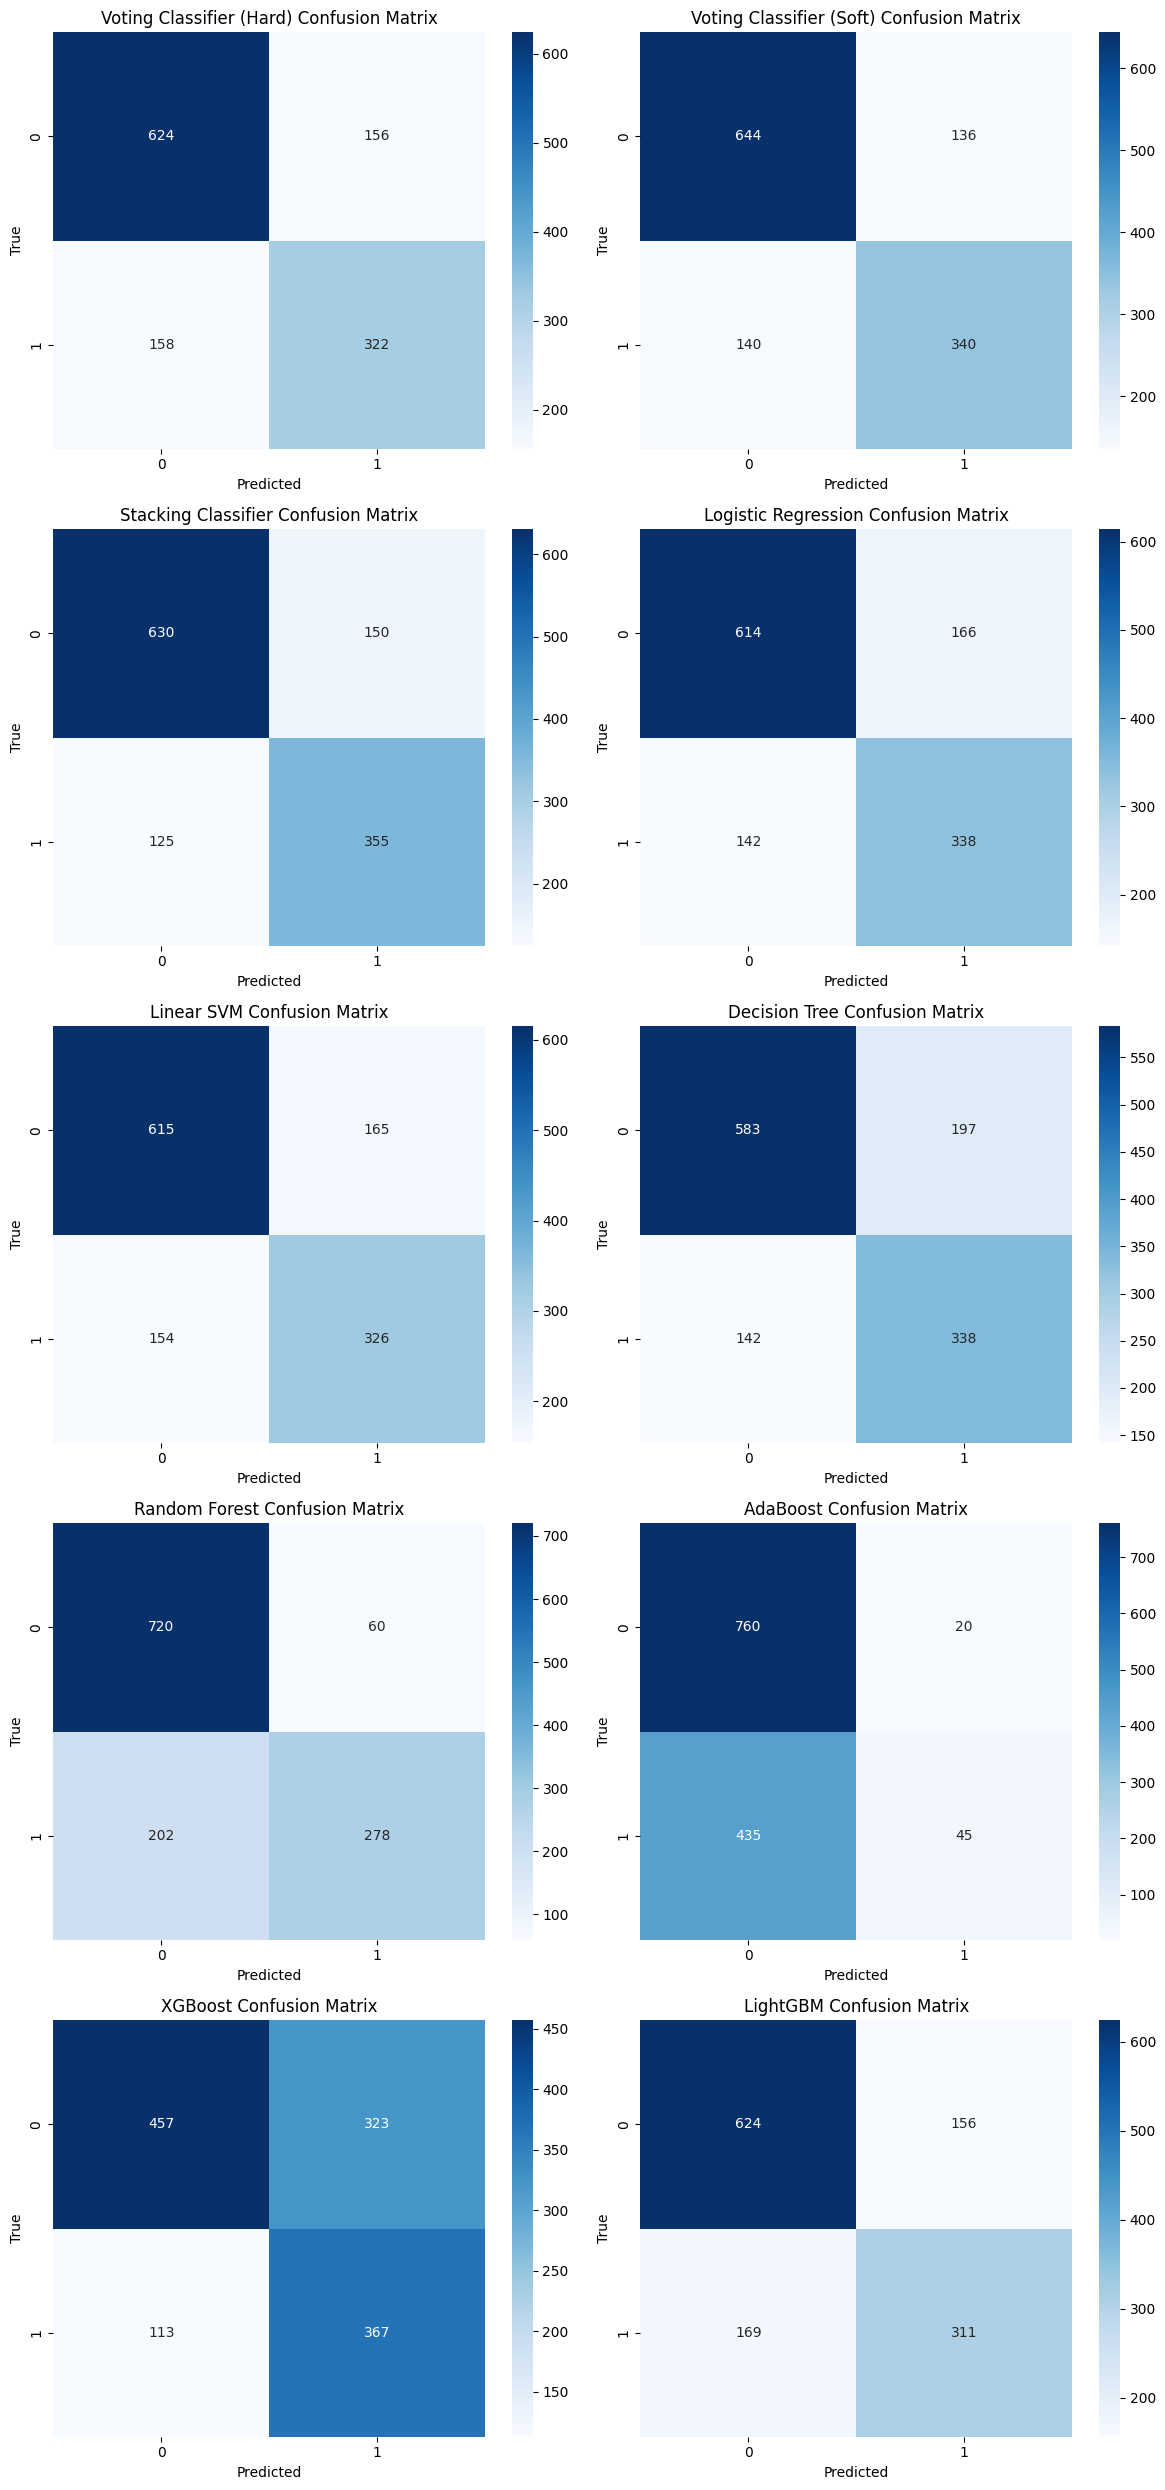


Model Performance Summary:
Voting Classifier (Hard)       | Accuracy: 0.7508 | F1 Score: 0.7356
Voting Classifier (Soft)       | Accuracy: 0.7810 | F1 Score: 0.7674
Stacking Classifier            | Accuracy: 0.7817 | F1 Score: 0.7708
Logistic Regression            | Accuracy: 0.7556 | F1 Score: 0.7432
Linear SVM                     | Accuracy: 0.7468 | F1 Score: 0.7328
Decision Tree                  | Accuracy: 0.7310 | F1 Score: 0.7204
Random Forest                  | Accuracy: 0.7921 | F1 Score: 0.7629
AdaBoost                       | Accuracy: 0.6389 | F1 Score: 0.4674
XGBoost                        | Accuracy: 0.6540 | F1 Score: 0.6522
LightGBM                       | Accuracy: 0.7421 | F1 Score: 0.7251


In [19]:
n_models = len(models)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols
plt.figure(figsize=(12, 5 * n_rows))
results = []

for idx, (model_name, model) in enumerate(tqdm(models.items(), desc="Training Models", total=n_models)):
    print(f"\nTraining: {model_name}")

    # Apply GridSearchCV if applicable
    if model_name in param_grids:
        grid = GridSearchCV(model, param_grids[model_name], cv=cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"Best Params for {model_name}: {grid.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_model = model

    # Cross-validation score
    scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation Accuracy (Mean ± Std): {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    # Test set performance
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append((model_name, acc, f1))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

# -------------------------------
# Model Performance Summary
# -------------------------------
print("\nModel Performance Summary:")
for model_name, acc, f1 in results:
    print(f"{model_name:30s} | Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

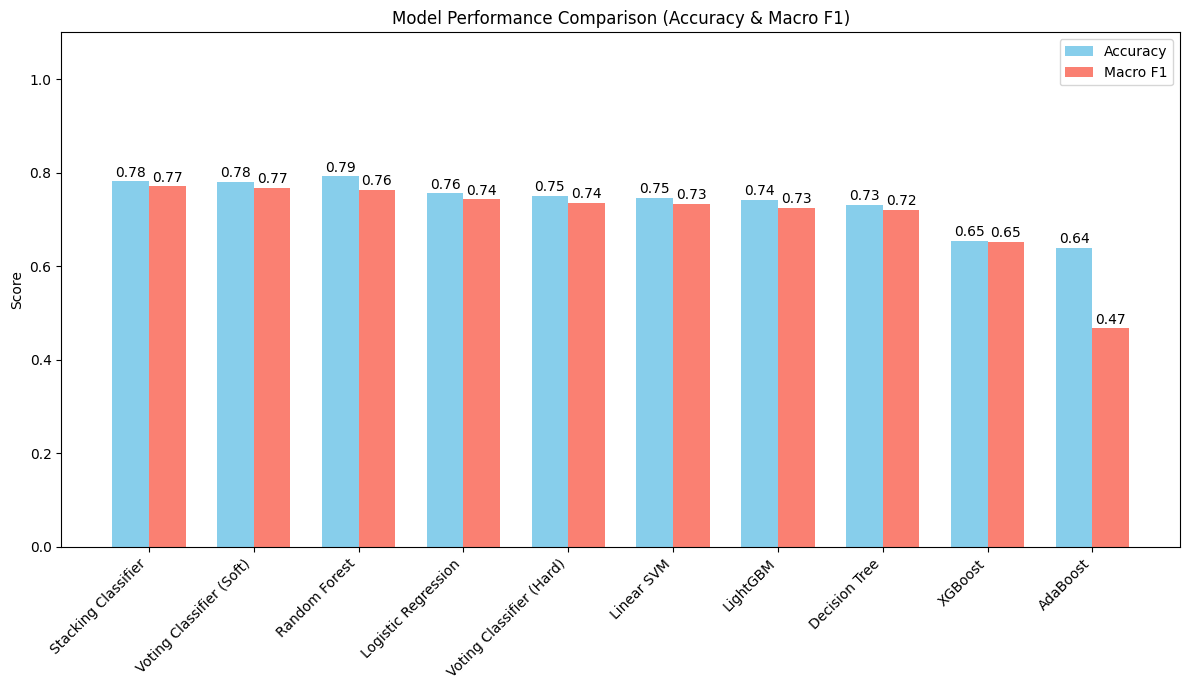

In [20]:
# -------------------------------
# Accuracy & F1 Score Plot (with value annotations)
# -------------------------------
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1"])
results_df = results_df.sort_values(by="Macro F1", ascending=False)

plt.figure(figsize=(12, 7))
bar_width = 0.35
x = np.arange(len(results_df))

# Plot bars
bars1 = plt.bar(x - bar_width/2, results_df["Accuracy"], bar_width, label='Accuracy', color='skyblue')
bars2 = plt.bar(x + bar_width/2, results_df["Macro F1"], bar_width, label='Macro F1', color='salmon')

# Annotate values on top of bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

# Final touches
plt.xticks(x, results_df["Model"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison (Accuracy & Macro F1)")
plt.ylim(0, 1.1)  # Optional: Keep a little space above bars for annotations
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

train = pd.read_csv('original/train.csv')
dev = pd.read_csv('original/dev.csv')
df = pd.concat([train, dev])
df.head()

,id,text,label
0,3268,Indha ariya kandupidippin moolam neenga solla ...,0
1,6239,@vijayakumarp7959 unmai therincha nee pesu,0
2,5859,Inga erukka yella dev... boys vadakkan vadakk...,1
3,3519,பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...,1
4,5136,Mumbai Bangalore la 80% percentage outsiders,1


In [25]:
df.shape

(6299, 3)

In [27]:
df["label"].value_counts()

label
0    3900
1    2399
Name: count, dtype: int64

In [28]:
import pandas as pd

df = pd.read_csv("augmented_data.csv")
df.head()

,text,label
0,"HOSUR also mini North India bro ,,",0
1,@rajaa9979 வணிகர் சங்கங்களின் தலைமை தமிழரிடத...,0
2,Already Telangana becomes Hindi belt 🥺,0
3,வட மாநிலத்தொழிளார் தமிழ்நாட்டினரரை தாக்கினால் ...,0
4,தமிழன் வட இந்தியாவிலும் கேரளா ஆந்திரா கர்ந...,0


In [29]:
df.shape

(7197, 2)

In [30]:
df["label"].value_counts()

label
1    3864
0    3333
Name: count, dtype: int64

In [58]:
print(results)

[('Voting Classifier (Hard)', 0.6777777777777778, 0.6665708536935901), ('Voting Classifier (Soft)', 0.6791666666666667, 0.6699999999999999), ('Stacking Classifier', 0.7027777777777777, 0.6996906860843821), ('Logistic Regression', 0.7048611111111112, 0.7035709528595473), ('Linear SVM', 0.7041666666666667, 0.7027901216862824), ('Decision Tree', 0.6229166666666667, 0.6211978445793049), ('Random Forest', 0.6722222222222223, 0.6562932996207332), ('AdaBoost', 0.6201388888888889, 0.6118041732234181), ('XGBoost', 0.6340277777777777, 0.5822412913262551), ('LightGBM', 0.6777777777777778, 0.6768777226688538)]
